In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
df=pd.read_csv('IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv')

In [22]:
label_encoder = skl.preprocessing.LabelEncoder()
def LabelEnc(column):
  label_encoder = LabelEncoder()
  mapped_education = pd.Series(label_encoder.fit_transform(df[column]))
  df[column]=mapped_education

lst=['Countries','Local','Industry Sector','Accident Level','Potential Accident Level','Genre','Employee or Third Party']
for i in lst:
  LabelEnc(i)

In [23]:
df=df.drop_duplicates()

df.columns = map(str.lower, df.columns)

df['data'] = df['data'].apply(pd.to_datetime)

df['day'] = [d.date() for d in df['data']]
df['time'] = [d.time() for d in df['data']]
df=df.drop(columns='data')
df=df.drop(columns='time')

df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

df['critical risk'].str.lower()

df=df.rename(columns={'local': 'city','genre': 'gender','employee ou terceiro': 'employee or third party','risco critico': 'critical risk','day':'date'})

In [24]:
df

,unnamed: 0,countries,city,industry sector,accident level,potential accident level,gender,employee or third party,critical risk,description,date
0,0,0,0,1,0,3,1,1,Pressed,While removing the drill rod of the Jumbo 08 f...,2016-01-01
1,1,1,1,1,0,3,1,0,Pressurized Systems,During the activation of a sodium sulphide pum...,2016-01-02
2,2,0,2,1,0,2,1,2,Manual Tools,In the sub-station MILPO located at level +170...,2016-01-06
3,3,0,3,1,0,0,1,1,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016-01-08
4,4,0,3,1,3,3,1,1,Others,Approximately at 11:45 a.m. in circumstances t...,2016-01-10
...,...,...,...,...,...,...,...,...,...,...,...
420,434,0,3,1,0,2,1,1,Others,"Being approximately 5:00 a.m. approximately, w...",2017-07-04
421,435,0,2,1,0,1,0,0,Others,The collaborator moved from the infrastructure...,2017-07-04
422,436,1,8,0,0,1,1,0,Venomous Animals,During the environmental monitoring activity i...,2017-07-05
423,437,1,4,0,0,1,1,0,Cut,The Employee performed the activity of strippi...,2017-07-06


## Удаления ненужных колонок

In [25]:
df=df.drop(columns='description')
df=df.drop(columns='critical risk')
df=df.drop(columns='unnamed: 0')
df=df.drop(columns='date')

In [26]:
df

,countries,city,industry sector,accident level,potential accident level,gender,employee or third party
0,0,0,1,0,3,1,1
1,1,1,1,0,3,1,0
2,0,2,1,0,2,1,2
3,0,3,1,0,0,1,1
4,0,3,1,3,3,1,1
...,...,...,...,...,...,...,...
420,0,3,1,0,2,1,1
421,0,2,1,0,1,0,0
422,1,8,0,0,1,1,0
423,1,4,0,0,1,1,0


In [27]:
# Выбор фичей
feature = df.drop('gender', axis=1)

In [28]:
# Выбор целей
target = df['gender']

In [29]:
# Разделение на тестовую и обучающую выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)

In [30]:
print('Shape of training feature:', X_train.shape)

Shape of training feature: (340, 6)


In [31]:
print('Shape of testing feature:', X_test.shape)

Shape of testing feature: (85, 6)


## Функция для вычисления оценок

In [32]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Прогнозирование тестовых данных
    y_pred = model.predict(x_test)

    # Вычисление accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Вычисление AUC
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Визуализация confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

In [33]:
from sklearn import tree

# Построение дерева решенией
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Оценка модели
dtc_eval = evaluate_model(dtc, X_test, y_test)

# Вывод результатов
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Cohens Kappa Score:', dtc_eval['kappa'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.9058823529411765
Precision: 0.95
Recall: 0.95
F1 Score: 0.9500000000000001
Cohens Kappa Score: 0.15000000000000002
Area Under Curve: 0.61375
Confusion Matrix:
 [[ 1  4]
 [ 4 76]]


In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
rf_eval = evaluate_model(rf, X_test, y_test)

In [35]:
from sklearn.neighbors import KNeighborsClassifier
kNN = KNeighborsClassifier(n_neighbors=20) 
kNN.fit(X_train, y_train)
knn_eval = evaluate_model(kNN, X_test, y_test)

In [36]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf_eval = evaluate_model(clf, X_test, y_test)

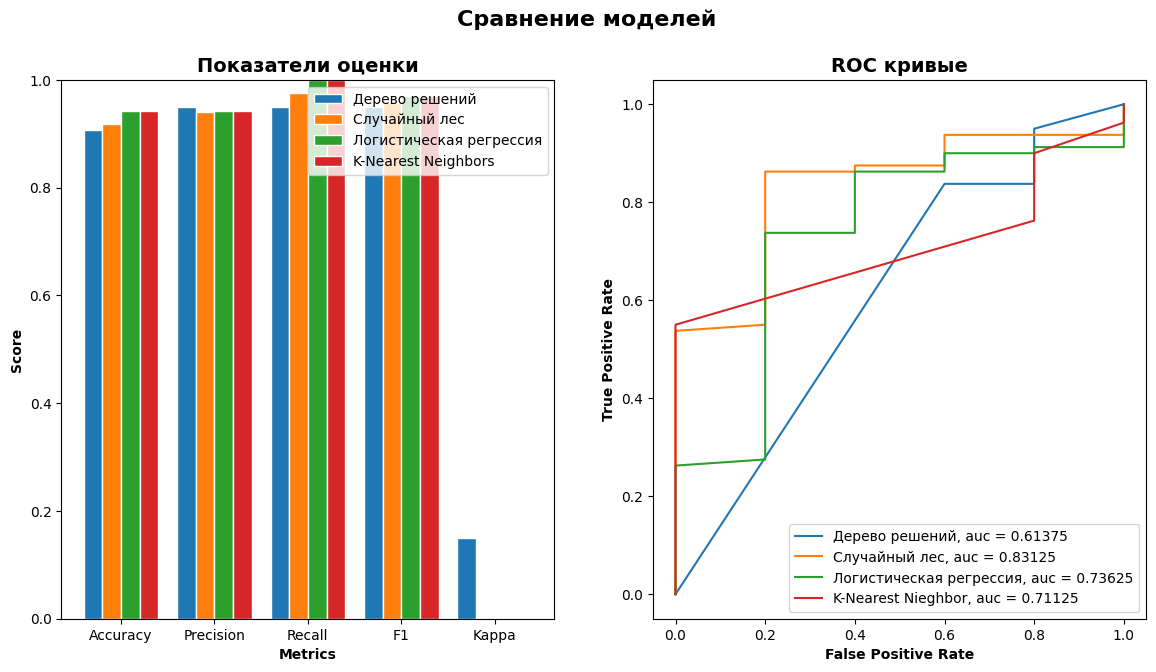

In [37]:
# Инициализация фигуры с двумя графиками
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Сравнение моделей', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# Первый график
## установка размера столбцов
barWidth = 0.2
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1'], dtc_eval['kappa']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
clf_score = [clf_eval['acc'], clf_eval['prec'], clf_eval['rec'], clf_eval['f1'], clf_eval['kappa']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1'], knn_eval['kappa']]


## установка позиций столбцов на оси X
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

## создание графика
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Дерево решений')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Случайный лес')
ax1.bar(r3, clf_score, width=barWidth, edgecolor='white', label='Логистическая регрессия')
ax1.bar(r4, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')

## Конфигурация осей X и Y 
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Создание легенды и названия
ax1.set_title('Показатели оценки', fontsize=14, fontweight='bold')
ax1.legend()

# Второй график
## Сравнение ROC кривых
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Дерево решений, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Случайный лес, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(clf_eval['fpr'], clf_eval['tpr'], label='Логистическая регрессия, auc = {:0.5f}'.format(clf_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))

## Конфигурация осей X и Y 
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Создание легенды и названия
ax2.set_title('ROC кривые', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

## Подбор оптимальных параметров для модели

In [38]:
from sklearn.model_selection import GridSearchCV

# Создание сетки параметров на основе результатов случайного поиска
param_grid = {
    'max_depth': [50, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500, 750, 1000]
}

# Создание базовой модели
rf_grids = RandomForestClassifier(random_state=0)

# Инициализация модели grid search
grid_search = GridSearchCV(estimator=rf_grids, param_grid=param_grid, scoring='recall',
                           cv=5, n_jobs=-1, verbose=2)

# Подгонка grid search к данным
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


{'max_depth': 50,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [39]:
best_grid = grid_search.best_estimator_

# Оценка модели
best_grid_eval = evaluate_model(best_grid, X_test, y_test)

# Вывод результата
print('Accuracy:', best_grid_eval['acc'])
print('Precision:', best_grid_eval['prec'])
print('Recall:', best_grid_eval['rec'])
print('F1 Score:', best_grid_eval['f1'])
print('Cohens Kappa Score:', best_grid_eval['kappa'])
print('Area Under Curve:', best_grid_eval['auc'])
print('Confusion Matrix:\n', best_grid_eval['cm'])

Accuracy: 0.9411764705882353
Precision: 0.9411764705882353
Recall: 1.0
F1 Score: 0.9696969696969697
Cohens Kappa Score: 0.0
Area Under Curve: 0.8262499999999999
Confusion Matrix:
 [[ 0  5]
 [ 0 80]]


## Сравнение оптимизированной модели с обычной 

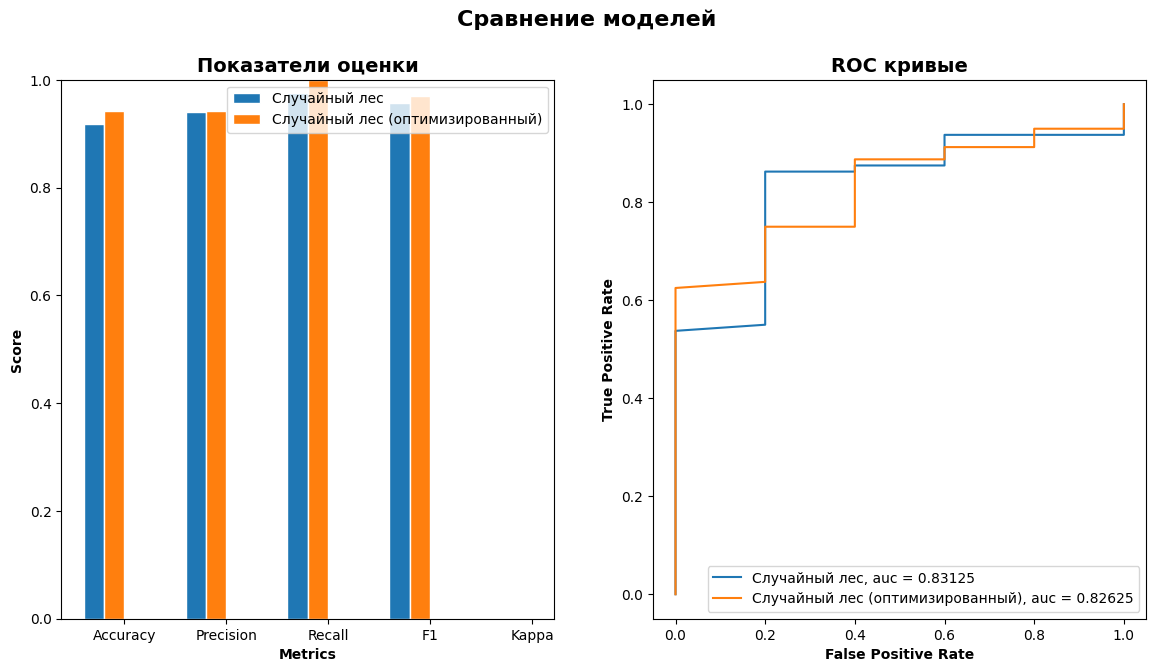

In [41]:
# Инициализация фигуры с двумя графиками
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Сравнение моделей', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# Первый график
## установка размера столбцов
barWidth = 0.2

rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
bg_score = [best_grid_eval['acc'], best_grid_eval['prec'], best_grid_eval['rec'], best_grid_eval['f1'], best_grid_eval['kappa']]


## установка позиций столбцов на оси X
r1 = np.arange(len(rf_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

## создание графика

ax1.bar(r1, rf_score, width=barWidth, edgecolor='white', label='Случайный лес')
ax1.bar(r2, bg_score, width=barWidth, edgecolor='white', label='Случайный лес (оптимизированный)')

## Конфигурация осей X и Y 
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Создание легенды и названия
ax1.set_title('Показатели оценки', fontsize=14, fontweight='bold')
ax1.legend()

# Второй график
## Сравнение ROC кривых

ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Случайный лес, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(best_grid_eval['fpr'], best_grid_eval['tpr'], label='Случайный лес (оптимизированный), auc = {:0.5f}'.format(best_grid_eval['auc']))
## Конфигурация осей X и Y 
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Создание легенды и названия
ax2.set_title('ROC кривые', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()